<a href="https://colab.research.google.com/github/francescoFavareto/handwritingAnalysis/blob/main/handwritingAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

It is necessary to upload the images through Colab’s graphical interface for each test.
The IAM dataset is divided into 657 folders, each containing handwritten text images from a single author.
I decided to locally modify the dataset structure by removing the folders and placing all images into a single directory, while adding the original folder name as a prefix to each file name, thus preserving the author information.
For example, the image “a01-000u” contained in folder “000” becomes “000a01-000u”.

#Image Reading and Segmentation

In [ ]:
def normalize_word_image(img, target_height=64, baseline_row=56):
    """
    Normalizes a handwritten word image (binary):
    - Crops white margins
    - Aligns the baseline to baseline_row (if detectable)
    - Resizes to target_height
    """

    #Invert to facilitate processing (ink = 255)
    img_inv = 255 - img

    # Find bounding box
    coords = cv2.findNonZero(img_inv)
    if coords is None:
        return 255 * np.ones((target_height, 1), dtype=np.uint8)

    x, y, w, h = cv2.boundingRect(coords)
    cropped = img[y:y+h, x:x+w]

    # Horizontal projection to estimate the baseline
    cropped_inv = 255 - cropped
    horiz_proj = np.sum(cropped_inv > 0, axis=1)

    if np.max(horiz_proj) < 5:  # too little content
        baseline_idx = h - 1
    else:
        baseline_idx = np.argmax(horiz_proj)

    # Calculate shift to bring the baseline to the desired row
    shift = baseline_row - baseline_idx

    # Add padding at the top/bottom if needed
    top_pad = max(0, -shift)
    bottom_pad = max(0, shift)
    padded = cv2.copyMakeBorder(cropped, top_pad, bottom_pad, 0, 0, cv2.BORDER_CONSTANT, value=255)

    # Apply translation
    rows, cols = padded.shape
    M = np.float32([[1, 0, 0], [0, 1, shift]])
    shifted = cv2.warpAffine(padded, M, (cols, rows), borderValue=255)

    # Resize to fixed height
    scale = target_height / shifted.shape[0]
    new_width = int(shifted.shape[1] * scale)
    resized = cv2.resize(shifted, (new_width, target_height), interpolation=cv2.INTER_NEAREST)

    return resized

In [ ]:
# Main lists
all_lines_images = []        # List of segmented lines for each image
cropped_imgs = []            # Cropped images
binary_images = []           # Binarized images
labels_and_lines = []        # NEW list of label + line images (non '671')
labels_and_images = []       # NEW list of label + cropped image
X_unknown_lines = []

# Cartella contenente le immagini
folder_path = '/content/sample_data'

# Lista di tutti i file PNG nella cartella
image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]

for img_name in image_files:
    print(f"Processing {img_name} ...")

    # 1. Extract label
    label = img_name[:3]

    # 2. Load image
    img_pil = Image.open(os.path.join(folder_path, img_name)).convert('L')
    img_np = np.array(img_pil)

    # 3. Vertical crop
    height = img_np.shape[0]
    cropped_img = img_np[700:height-800, :]
    cropped_imgs.append(cropped_img)
    labels_and_images.append((label, cropped_img))

    # 4. Otsu binarization (white text on black background)
    _, binary = cv2.threshold(cropped_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    binary_images.append(binary)

    # 5. Horizontal projection + smoothing
    projection = np.sum(binary, axis=1)
    smoothed = gaussian_filter1d(projection, sigma=3)

    # 6. Line segmentation via thresholding
    threshold = np.max(smoothed) * 0.1
    lines = []
    in_text = False

    for i, val in enumerate(smoothed):
        if val > threshold and not in_text:
            start = i
            in_text = True
        elif val <= threshold and in_text:
            end = i
            in_text = False
            lines.append((start, end))

    # 7. Extract lines
    lines_images = []
    for (y1, y2) in lines:
        line_img = binary[y1:y2, :]
        line_img = 255 - line_img  # black text on white background
        line_img_norm = normalize_word_image(line_img)
        lines_images.append(line_img)

    # Insert label as the first element della lista
    lines_images.insert(0, label)

    # Aggiunge la pagina nella lista corretta
    if (label == '000') | (label == '099'):
        X_unknown_lines.append(lines_images)
    else:
        labels_and_lines.append(lines_images)

Processing 100b03-025.png ...
Processing 097b02-097.png ...
Processing 099b02-105.png ...
Processing 098b02-102.png ...
Processing 095b02-035.png ...
Processing 096b02-045.png ...
Processing 000a01-000u.png ...


In [ ]:
# np.set_printoptions(threshold=1000000000)

In [ ]:
# import matplotlib.pyplot as plt

# #per il test prova X_test[1][1]

# plt.imshow(X_test[0][1], cmap='gray')
# plt.axis('off')
# plt.show()

In [ ]:
def segment_words_from_line(line_img, min_gap_width=25, min_word_width=20):
    """
    Segments a single line of text (numpy image) into words using vertical projection.

    Args:
        line_img (np.ndarray): Grayscale image of a single line of text.
        min_gap_width (int): Minimum gap width to consider as a word separator.
        min_word_width (int): Minimum width for a blob to be considered a word.

    Returns:
        List[np.ndarray]: List of numpy images, each representing a segmented word.
    """
    binary = line_img.copy()  # already binary with black text on white background


    # Invert for projection calculation (background black, text white)
    inv = 255 - binary

    # Vertical projection
    vertical_profile = np.sum(inv, axis=0)

    # Empty columns = possible space
    empty_columns = vertical_profile < 10

    # Find gaps wide enough to separate words
    word_boundaries = []
    in_gap = False
    start = 0

    for i, is_empty in enumerate(empty_columns):
        if is_empty and not in_gap:
            start = i
            in_gap = True
        elif not is_empty and in_gap:
            end = i
            if end - start >= min_gap_width:
                word_boundaries.append((start, end))
            in_gap = False

    # Segment words between gaps
    word_images = []
    prev_end = 0

    for gap_start, gap_end in word_boundaries:
        word = binary[:, prev_end:gap_start]
        if word.shape[1] > min_word_width:
            word_images.append(word)
        prev_end = gap_end

    # Last word
    last_word = binary[:, prev_end:]
    if last_word.shape[1] > min_word_width:
        word_images.append(last_word)

    return word_images

In [ ]:
#Segment each word within the lines
labels_and_words = []
number_of_words_train = 0
for idx, image in enumerate(labels_and_lines):
  lines = []
  for line in image[1:]:
    words = []
    words.append(image[0])
    words.extend(segment_words_from_line(line))
    lines.append(words)
    number_of_words_train += len(words)-1
  labels_and_words.append(lines)
number_of_train_couple = number_of_words_train*(number_of_words_train-1)//2
print('the number of words in total in trainSet is:', number_of_words_train)
print('the number of couple in trainSet is :', number_of_train_couple)

the number of words in total in trainSet is: 277
the number of couple in trainSet is : 38226


In [ ]:
#Segments the words within the lines of the test images
X_unknown_words = []
number_of_words_test = 0
for image in X_unknown_lines:
  lines = []
  for line in image[1:]:
    words = []
    words.append(image[0])
    words.extend(segment_words_from_line(line))
    lines.append(words)
    number_of_words_test += len(words)-1
  X_unknown_words.append(lines)
number_of_test_couple = number_of_words_test*(number_of_words_test-1)//2
print('the number of words in total in testSet is:', number_of_words_test)
print('the number of couple in trainSet is :', number_of_test_couple)

the number of words in total in testSet is: 147
the number of couple in trainSet is : 10731


#Feature extraction and dataset creation

In [ ]:
import random
# 1. Appiattisci X_unknown_words (solo immagini)
flat_test = []
for sublist in X_unknown_words:
    for inner in sublist:
        flat_test.extend(inner[1:])  # ignora inner[0] (stringa)

# 2. Appiattisci labels_and_words (solo immagini)
flat_train = []
for sublist in labels_and_words:
    for inner in sublist:
        flat_train.extend(inner[1:])

# Numero immagini da estrarre dal train
num_to_extract = min(len(flat_train), len(flat_test))  # in questo esempio 100

# 3. Estrai num_to_extract immagini uniche dal train
selected_train_images = random.sample(flat_train, num_to_extract)

# 4. Crea coppie: ogni immagine test abbinata a tutte le estratte
X_CASE1 = []
for img_test in flat_test:
    for img_train in selected_train_images:
        X_CASE1.append((img_test, img_train))

# 5. Aggiorna labels_and_words rimuovendo le immagini usate
for img_used in selected_train_images:
    for i, sublist in enumerate(labels_and_words):
        for j, inner in enumerate(sublist):
            labels_and_words[i][j] = [inner[0]] + [img for img in inner[1:] if not np.array_equal(img, img_used)]

print(f"Creati {len(X_CASE1)} abbinamenti ({len(flat_test)} test * {len(selected_train_images)} train).")
print(f"Immagini rimanenti nel train: {sum(len(inner)-1 for sub in labels_and_words for inner in sub)}")

Creati 21609 abbinamenti (147 test * 147 train).
Immagini rimanenti nel train: 130


In [ ]:
plt.imshow(labels_and_lines[0][1], cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
def extract_direction_histogram(img, num_bins=8):
    """
    Estrae edge map con Canny e costruisce un istogramma delle direzioni locali.
    """

    # Edge detection (usa immagine già normalizzata e binaria)
    edges = cv2.Canny(img, threshold1=50, threshold2=150)

    # Gradienti x, y su immagine originale (non edges)
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

    # Calcolo angolo e magnitudo
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    angle = np.arctan2(grad_y, grad_x)  # angolo in radianti [-π, π]
    angle_deg = np.degrees(angle) % 180  # in [0, 180)

    # Filtra solo nei punti edge
    mask = edges > 0
    selected_angles = angle_deg[mask]
    selected_magnitudes = magnitude[mask]

    # Istogramma pesato per magnitudo
    hist, _ = np.histogram(selected_angles, bins=num_bins, range=(0, 180), weights=selected_magnitudes)

    # Normalizza il vettore
    hist_norm = hist / (np.sum(hist) + 1e-6)

    return hist_norm

In [ ]:
#creo feature hog
X_test_CASE1 = []
for tupla in X_CASE1:
  x1 = extract_direction_histogram(tupla[0])
  x2 = extract_direction_histogram(tupla[1])
  X_test_CASE1.append(np.concatenate([x1, x2]))

In [ ]:
#crea couple_words_01 per il trainSet, lista di tuple uniche che indica se due parole segmentate appartengono allo stesso autore

couple_words_01 = []
Y_siamese = []

# Estrai tutte le triple (label, immagine, indice i, j)
flat_images = []  # ogni elemento sarà (label, img, i, j)
for i, sotto_lista in enumerate(labels_and_words):
    for j, interno in enumerate(sotto_lista):
        label = interno[0]
        for k in range(1, len(interno)):
            flat_images.append((label, interno[k], i, j))

# Ora confronta tutte le coppie
for idx1 in range(len(flat_images)):
    for idx2 in range(idx1 + 1, len(flat_images)):
        label1, img1, _, _ = flat_images[idx1]
        label2, img2, _, _ = flat_images[idx2]
        same_label = int(label1 == label2)
        Y_siamese.append(same_label)
        couple_words_01.append((img1, img2, same_label))

In [ ]:
len(Y_siamese)

8385

In [ ]:
import random

In [ ]:
# couple_wordsR = random.sample(couple_words, 10000)

In [ ]:
import random
import numpy as np

# Shuffle con seed per riproducibilità
random.seed(42)

# Mescola le tuple
couple_words_shuffled = couple_words_01.copy()
random.shuffle(couple_words_shuffled)

# Calcola quante vanno nel test (25%)
test_size = len(couple_words_shuffled) // 4

# Suddivisione
test_tuples = couple_words_shuffled[:test_size]
train_tuples = couple_words_shuffled[test_size:]

# Liste train
X = []
Y = []

# Liste test
X_test_CASE2 = []
Y_test_CASE2 = []

# Train
for tupla in train_tuples:
    x1 = extract_direction_histogram(tupla[0])
    x2 = extract_direction_histogram(tupla[1])
    y = tupla[2]
    X.append(np.concatenate([x1, x2]))
    Y.append(y)

# Test
for tupla in test_tuples:
    x1 = extract_direction_histogram(tupla[0])
    x2 = extract_direction_histogram(tupla[1])
    y = tupla[2]
    X_test_CASE2.append(np.concatenate([x1, x2]))
    Y_test_CASE2.append(y)

In [ ]:
len(X)

6289

In [ ]:
#crea couple_words per il testSet, lista di tuple uniche che indica se due parole segmentate appartengono allo stesso autore

couple_words_unknown = []
Ytest_siamese = []

# Estrai tutte le triple (label, immagine, indice i, j)
flat_imagestest = []  # ogni elemento sarà (label, img, i, j)
for i, sotto_lista in enumerate(X_unknown_words):
    for j, interno in enumerate(sotto_lista):
        label = interno[0]
        for k in range(1, len(interno)):
            flat_imagestest.append((label, interno[k], i, j))

# Ora confronta tutte le coppie
for idx1 in range(len(flat_imagestest)):
    for idx2 in range(idx1 + 1, len(flat_imagestest)):
        label1, img1, _, _ = flat_imagestest[idx1]
        label2, img2, _, _ = flat_imagestest[idx2]
        same_label = int(label1 == label2)
        Ytest_siamese.append(same_label)
        couple_words_unknown.append((img1, img2, same_label))

In [ ]:
len(couple_words_unknown)

10731

In [ ]:
#creo feature hog e (volendo) labels per il test
X_test_CASE3 = []
Ytest_CASE3 = []
for tupla in couple_words_unknown:
  x1 = extract_direction_histogram(tupla[0])
  x2 = extract_direction_histogram(tupla[1])
  y = tupla[2]
  X_test_CASE3.append(np.concatenate([x1, x2]))
  Ytest_CASE3.append(y)

In [ ]:
#controlla la composizione di train e test
for lines in labels_and_lines:
  print('train', lines[0])

for lines in X_unknown_lines:
  print('test', lines[0])

train 097
train 098
train 095
train 096
test 100
test 099
test 000


In [ ]:
#CASE1 Y_test quando confrontiamo X_test3 con len(X_test3) elementi estratti randomicamente dal trainSet (aurori noti con ignoti) è semplicemente un vettore di zeri
#lungo len(X_test3)

Ytest_CASE1 = np.zeros(len(X_test_CASE1))

#Classification algorithms

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42) credo non serva

In [ ]:
#modello svc
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [ ]:
len(X)

6289

In [ ]:
 #selezione iperparametri migliori

grid = {'C':      np.logspace(-4,3,10),
       'kernel': ['rbf'],                     #per aumentare velocità: 'kernel': ['linear', 'rbf']
        'gamma':  np.logspace(-4,3,10)
        }

MS = GridSearchCV(estimator = SVC(),
                  param_grid = grid,
                  scoring = 'f1',
                  cv = 10, #cross validation numner of folds
                  verbose = 1
                  )

H = MS.fit(X, Y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [ ]:
#creo modello con parametri migliori
M = SVC(C = H.best_params_['C'],  #da runnare
        kernel = H.best_params_['kernel'],
        gamma = H.best_params_['gamma']
        )

M.fit(X, Y)

SVC(C=np.float64(1000.0), gamma=np.float64(27.825594022071257))

#Results Analysis

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

0.7034106159470591

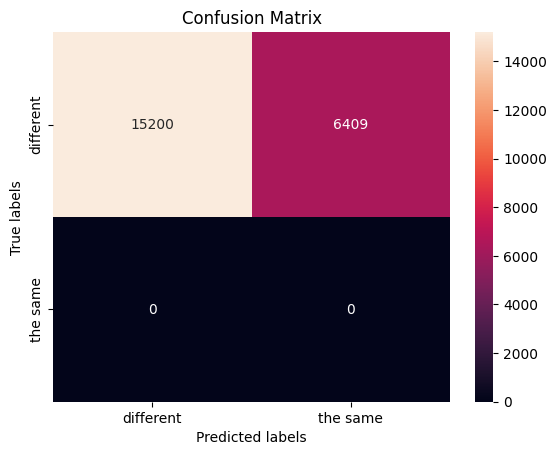

In [ ]:
#CASE1
Ypred_CASE1 = M.predict(X_test_CASE1)
accuracy_score(Ytest_CASE1,Ypred_CASE1)
cm = confusion_matrix(Ytest_CASE1,Ypred_CASE1)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['different','the same']);
ax.yaxis.set_ticklabels(['different','the same']);

accuracy_score(Ytest_CASE1,Ypred_CASE1)

0.987118320610687

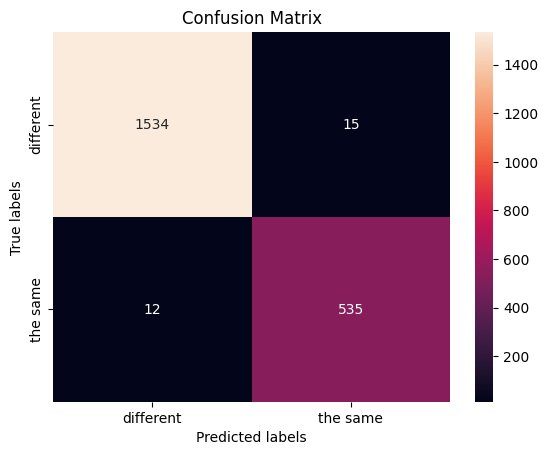

In [ ]:
#CASE2
Ypred_CASE2 = M.predict(X_test_CASE2)
accuracy_score(Y_test_CASE2,Ypred_CASE2)
cm = confusion_matrix(Y_test_CASE2,Ypred_CASE2)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['different','the same']);
ax.yaxis.set_ticklabels(['different','the same']);

accuracy_score(Y_test_CASE2,Ypred_CASE2)

0.5579163172118162

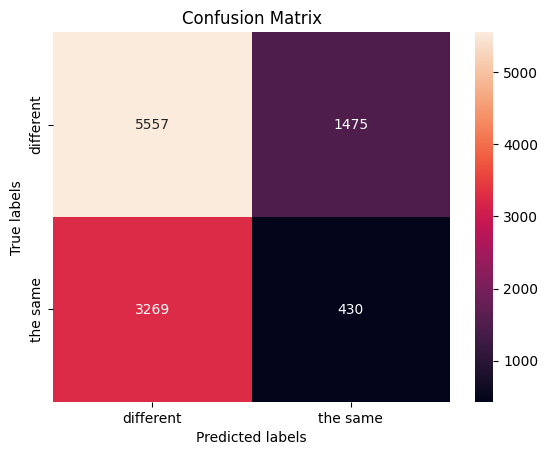

In [ ]:
#CASE3
Ypred_CASE3 = M.predict(X_test_CASE3)
accuracy_score(Ytest_CASE3,Ypred_CASE3)
cm = confusion_matrix(Ytest_CASE3,Ypred_CASE3)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['different','the same']);
ax.yaxis.set_ticklabels(['different','the same']);

accuracy_score(Ytest_CASE3,Ypred_CASE3)